In [2]:
import warnings 
warnings.filterwarnings(action='ignore')

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

import math
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn.model_selection import cross_val_score,cross_validate

import shap
import eli5
from eli5.sklearn import PermutationImportance

import matplotlib.pyplot as plt
import matplotlib
plt.style.use('seaborn-whitegrid')

import seaborn as sns
plt.style.use('seaborn-whitegrid')
from pylab import rcParams
%matplotlib inline
import itertools

#한글폰트 적용
import matplotlib.font_manager as fm
path = 'C:/Windows/Fonts/gulim.ttc'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from ngboost import NGBRegressor # Natural Gradient Boost 
from ngboost.learners import default_tree_learner
from ngboost.distns import Normal
from ngboost.scores import MLE
from pgbm import PGBMRegressor   # Probabilistic Gradient 

In [3]:
def mse(y,pred):
    return mean_squared_error(y,pred)

def rmse(y,pred):
    return np.sqrt(mean_squared_error(y,pred))

def MAPE(y,pred):
    return np.mean(np.abs((y-pred)/y)*100)    

def SMAPE(y, pred):
    return np.mean((np.abs(y-pred))/(np.abs(y) + np.abs(pred)))

def evaluate_regr(y,pred): # 종합 평가지표 
    mse_val = mse(y,pred)
    rmse_val = rmse(y,pred)
    mae_val = mean_absolute_error(y,pred)
    mape_val = np.mean(np.abs((y-pred)/y)*100)
    smape_val = 100 / len(y) * np.sum(np.abs(pred - y) / (np.abs(y) + np.abs(pred)))
    print("MSE:{0:4F},RMSE:{1:4f},MAE:{2:4F},MAPE:{3:4F},SMAPE:{4:4F}".format(mse_val,rmse_val,mae_val,mape_val,smape_val))

In [4]:
data = pd.read_csv('잠실(보간법).csv',encoding='cp949')
data = data.drop(['Season'],axis=1)
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
data.head()

,수온(℃),DO,BOD,COD,SS,TN,TP,TOC,수소이온농도,전기전도도,암모니아성질소,질산성질소
Date,,,,,,,,,,,,
1994-01-01,2.0,11.9,2.2,2.8,6.0,3.261,0.116,2.0,7.4,192.0,0.470,2.146
1994-02-01,2.0,13.0,2.1,2.6,3.5,3.069,0.100,1.8,8.3,164.0,0.274,2.138
1994-03-01,7.0,11.0,2.2,2.6,6.5,4.502,0.262,1.8,8.0,161.0,0.680,1.419
1994-04-01,16.0,10.3,3.8,4.6,8.0,2.391,0.092,3.2,8.4,271.0,0.628,1.179
1994-05-01,18.0,9.2,3.5,4.2,8.5,3.517,0.082,2.9,7.6,125.0,0.526,1.130


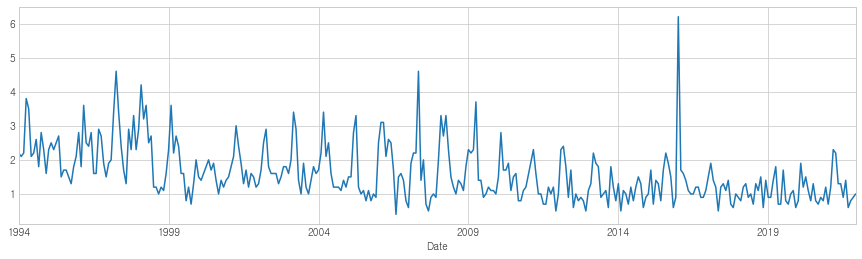

In [5]:
rcParams['figure.figsize'] = 15, 4
fig = data['BOD'].plot()

In [6]:
data['BOD'].iloc[260:267]

Date
2015-09-01    1.9
2015-10-01    1.5
2015-11-01    0.6
2015-12-01    0.9
2016-01-01    6.2
2016-02-01    1.7
2016-03-01    1.6
Name: BOD, dtype: float64

In [7]:
(1.9 + 1.5 + 0.6 + 0.9 + 1.7 + 1.6)/6

1.366666666666667

In [8]:
data['BOD'].iloc[264:265] = 1.3

In [9]:
data.shape

(336, 12)

In [10]:
#data = data.reset_index(drop=True)

#### Sliding Window

In [11]:
data_shift = data.copy()

In [12]:
data_shift.columns

Index(['수온(℃)', 'DO', 'BOD', 'COD', 'SS', 'TN', 'TP', 'TOC', '수소이온농도', '전기전도도',
       '암모니아성질소', '질산성질소'],
      dtype='object')

In [13]:
for s in range(1, 5):
    data_shift['수온(℃)_T-{}'.format(s)] = data_shift['수온(℃)'].shift(s)
    data_shift['DO_T-{}'.format(s)] = data_shift['DO'].shift(s)
    data_shift['BOD_T-{}'.format(s)] = data_shift['BOD'].shift(s)
    data_shift['COD_T-{}'.format(s)] = data_shift['COD'].shift(s)
    data_shift['SS_T-{}'.format(s)] = data_shift['SS'].shift(s)
    data_shift['TN_T-{}'.format(s)] = data_shift['TN'].shift(s)
    data_shift['TOC_T-{}'.format(s)] = data_shift['TOC'].shift(s)
    data_shift['수소이온농도_T-{}'.format(s)] = data_shift['수소이온농도'].shift(s)
    data_shift['전기전도도_T-{}'.format(s)] = data_shift['전기전도도'].shift(s)
    data_shift['암모니아성질소_T-{}'.format(s)] = data_shift['암모니아성질소'].shift(s)
    data_shift['질산성질소_T-{}'.format(s)] = data_shift['질산성질소'].shift(s)
    
data_time = data_shift.dropna()

In [14]:
split = -60
train_data = data_time[0:split]
test_data = data_time[split:] # 2017.01.01 ~ 2021.12.01

In [15]:
train_data.shape, test_data.shape

((272, 56), (60, 56))

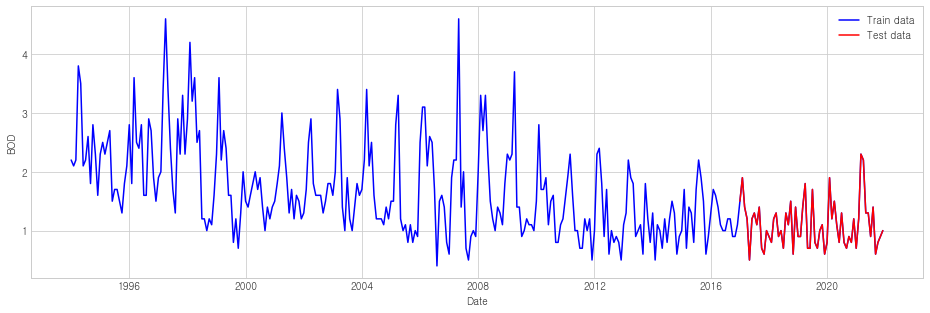

In [16]:
plt.figure(figsize=(16,5))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('BOD')
plt.plot(data['BOD'], 'blue', label='Train data')
plt.plot(test_data['BOD'], 'red', label='Test data')
plt.legend()

In [17]:
X_train = train_data.drop('BOD',axis=1,inplace=False)
X_test =  test_data.drop('BOD',axis=1,inplace=False)

In [18]:
y_train = train_data['BOD']
y_test = test_data['BOD']

In [19]:
y_test = y_test.reset_index(drop=True)

In [20]:
X_train.shape,X_test.shape

((272, 55), (60, 55))

In [21]:
y_train.shape,y_test.shape

((272,), (60,))

### 1.) GBM

MSE:0.107940,RMSE:0.328542,MAE:0.261365,MAPE:27.418752,SMAPE:12.011953


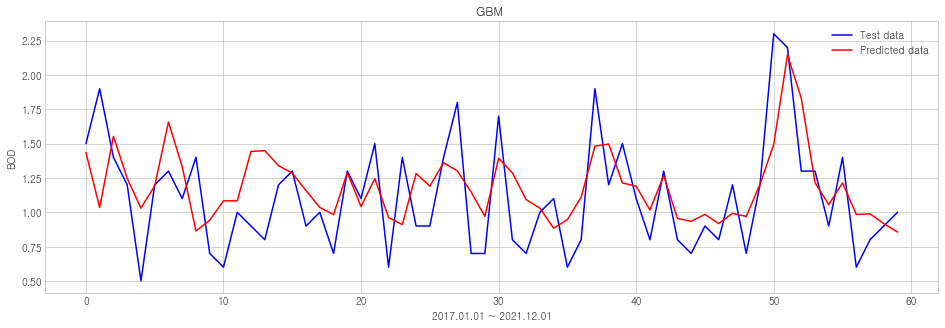

In [22]:
gbm = GradientBoostingRegressor(random_state=2021,n_estimators=100)
gbm.fit(X_train,y_train)
pred_gbm = gbm.predict(X_test)
evaluate_regr(y_test,pred_gbm)

plt.figure(figsize=(16,5))
plt.grid(True)
plt.title('GBM ')
plt.xlabel('2017.01.01 ~ 2021.12.01')
plt.ylabel('BOD')
plt.plot(y_test, 'blue', label='Test data')
plt.plot(pred_gbm, 'red', label='Predicted data')
plt.legend()

In [22]:
perm = PermutationImportance(gbm,random_state=0).fit(X_test,y_test)
eli5.show_weights(perm,feature_names=X_test.columns.to_list())

Weight,Feature
0.1941 ± 0.2036,TOC
0.1534 ± 0.1827,BOD_T-1
0.0754 ± 0.0423,수소이온농도
0.0654 ± 0.0493,COD
0.0613 ± 0.0274,수온(℃)
0.0441 ± 0.0404,암모니아성질소_T-1
0.0329 ± 0.0174,암모니아성질소_T-2
0.0292 ± 0.0249,질산성질소_T-4
0.0239 ± 0.0189,수온(℃)_T-2
0.0226 ± 0.0234,SS_T-1


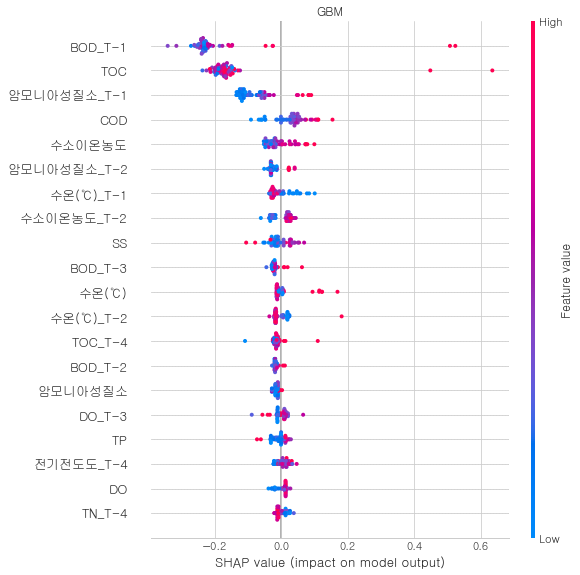

In [23]:
plt.title("GBM")
explainer = shap.TreeExplainer(gbm)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
plt.show()

Text(0.5, 0.98, 'GBM Prediction Results')

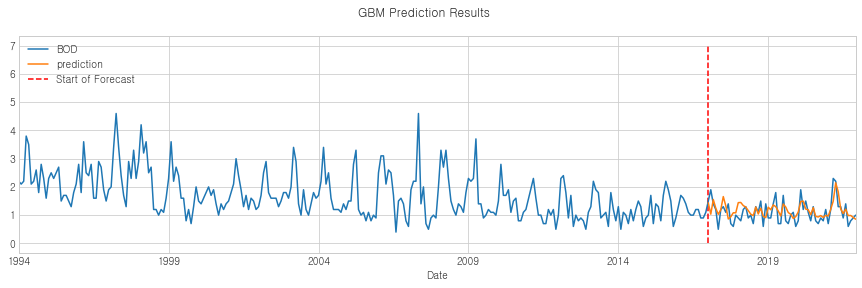

In [24]:
future_forecast = pd.DataFrame(pred_gbm, index=test_data.index, columns=['prediction'])
full_data_evaluation = pd.concat([data['BOD'], future_forecast], axis=1)
ax = full_data_evaluation.plot()
ax.vlines('2017-01-01',0,7,linestyle='--',color='r',label='Start of Forecast')
rcParams['figure.figsize'] = 14, 6
fig = ax.get_figure()
ax.legend(loc='upper left')
plt.suptitle(f'GBM Prediction Results')

### 1.) XGBoost 

In [25]:
XGBoost = XGBRegressor(random_state=2021,n_estimators=100,max_depth=10,min_child_weight=1)
XGBoost.fit(X_train,y_train)
pred_xgb = XGBoost.predict(X_test)

MSE:0.132191,RMSE:0.363581,MAE:0.288183,MAPE:29.767761,SMAPE:12.984644


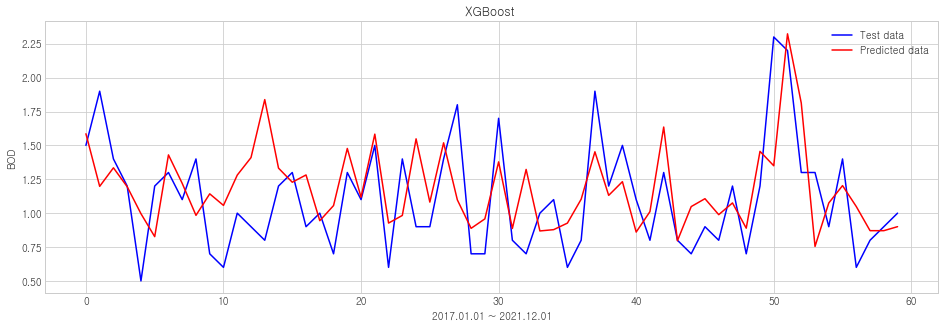

In [26]:
evaluate_regr(y_test,pred_xgb)

plt.figure(figsize=(16,5))
plt.grid(True)
plt.title('XGBoost ')
plt.xlabel('2017.01.01 ~ 2021.12.01')
plt.ylabel('BOD')
plt.plot(y_test, 'blue', label='Test data')
plt.plot(pred_xgb, 'red', label='Predicted data')
plt.legend()

In [27]:
perm = PermutationImportance(XGBoost,random_state=0).fit(X_test,y_test)
eli5.show_weights(perm,feature_names=X_test.columns.to_list())

Weight,Feature
0.2106 ± 0.3151,BOD_T-1
0.1911 ± 0.3240,TOC
0.1892 ± 0.0655,COD
0.0750 ± 0.0558,수소이온농도_T-1
0.0708 ± 0.1574,암모니아성질소_T-1
0.0280 ± 0.0041,암모니아성질소
0.0254 ± 0.0589,DO
0.0227 ± 0.0202,DO_T-3
0.0216 ± 0.0507,질산성질소_T-2
0.0211 ± 0.0044,SS_T-4


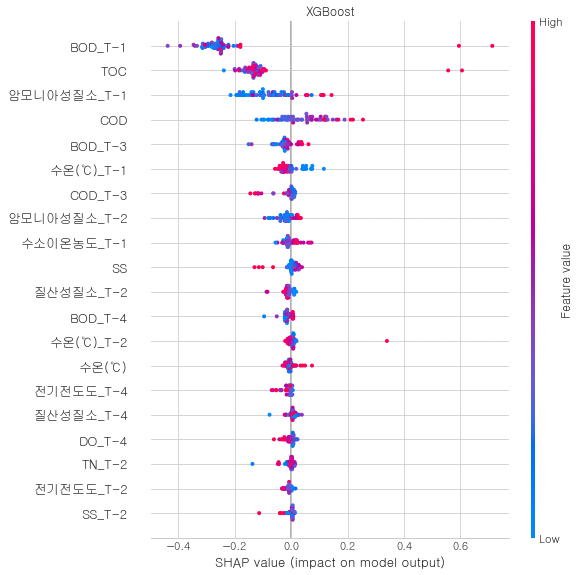

In [28]:
plt.title("XGBoost")
explainer = shap.TreeExplainer(XGBoost)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
plt.show()

Text(0.5, 0.98, 'XGBoost Prediction Results')

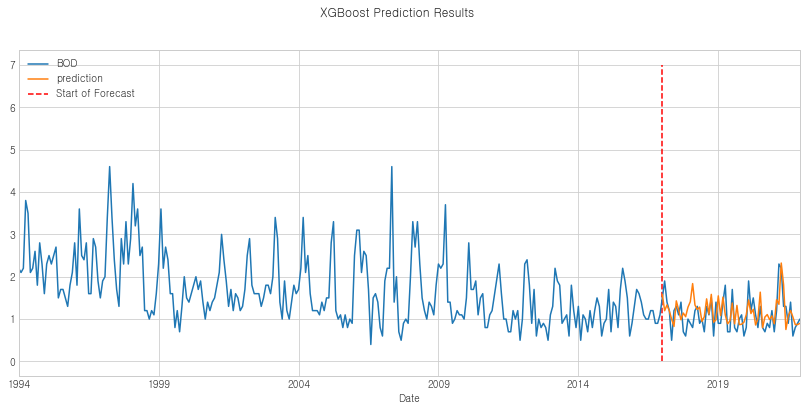

In [29]:
future_forecast = pd.DataFrame(pred_xgb, index=test_data.index, columns=['prediction'])
full_data_evaluation = pd.concat([data['BOD'], future_forecast], axis=1)
ax = full_data_evaluation.plot()
ax.vlines('2017-01-01',0,7,linestyle='--',color='r',label='Start of Forecast')
rcParams['figure.figsize'] = 14, 6
fig = ax.get_figure()
ax.legend(loc='upper left')
plt.suptitle(f'XGBoost Prediction Results')

### 2.) Light GBM

In [30]:
LightGBM_tune = LGBMRegressor(random_state=2021,n_estimators=100,max_depth=8,min_child_weight=1)
LightGBM_tune.fit(X_train,y_train)
pred_lgb_2 = LightGBM_tune.predict(X_test)


upper_LightGBM = LGBMRegressor(random_state=2021,n_estimators=100,max_depth=8,min_child_weight=1,objective = 'quantile', alpha = 0.95)
upper_LightGBM.fit(X_train, y_train)
upper_pred = upper_LightGBM.predict(X_test)

lower_LightGBM = LGBMRegressor(random_state=2021,n_estimators=100,max_depth=8,min_child_weight=1,objective = 'quantile', alpha = 1 - 0.95)
lower_LightGBM.fit(X_train, y_train)
lower_pred = lower_LightGBM.predict(X_test)

In [31]:
predictions = pd.DataFrame(pred_lgb_2, columns=['Predictions'])
predictions_upper = pd.DataFrame(upper_pred, columns=['Predictions_upper'])
predictions_lower = pd.DataFrame(lower_pred, columns=['Predictions_lower'])

y_test_lgb_reset_index = y_test.reset_index(drop=True)
y_test_lgb_reset_index = pd.DataFrame(y_test_lgb_reset_index,columns=['BOD'])

df_figure_lgb = pd.concat([y_test_lgb_reset_index, predictions, predictions_lower, predictions_upper], axis=1)

MSE:0.107045,RMSE:0.327178,MAE:0.254955,MAPE:25.186137,SMAPE:11.503390


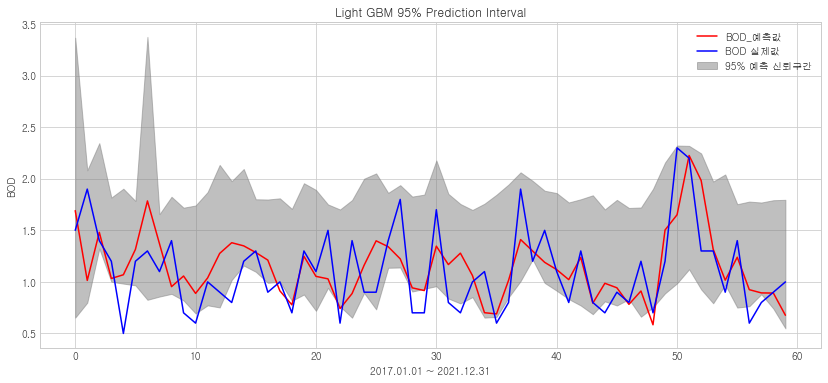

In [32]:
evaluate_regr(y_test,pred_lgb_2)

fig, ax = plt.subplots(figsize=(14, 6))
plt.plot(df_figure_lgb.index, df_figure_lgb.Predictions, label = 'BOD_예측값', color='r', lw=1.5)
plt.fill_between(df_figure_lgb.index, df_figure_lgb.Predictions_lower,  df_figure_lgb.Predictions_upper,label = '95% 예측 신뢰구간', color='gray', alpha=0.5)
plt.plot(df_figure_lgb.index, df_figure_lgb['BOD'], label = 'BOD 실제값', color='b', lw=1.5)
ax.legend(fontsize = 10)
plt.title('Light GBM 95% Prediction Interval')
plt.xlabel('2017.01.01 ~ 2021.12.31')
plt.ylabel('BOD')
plt.show()

In [33]:
perm = PermutationImportance(LightGBM_tune,random_state=0).fit(X_test,y_test)
eli5.show_weights(perm,feature_names=X_test.columns.to_list())

Weight,Feature
0.1638 ± 0.1438,TOC
0.1320 ± 0.1654,BOD_T-1
0.1036 ± 0.0845,COD
0.0784 ± 0.0984,수온(℃)_T-1
0.0779 ± 0.0266,수소이온농도
0.0440 ± 0.0299,질산성질소_T-4
0.0352 ± 0.0138,수소이온농도_T-1
0.0316 ± 0.0412,DO_T-3
0.0274 ± 0.0132,TN_T-4
0.0195 ± 0.0375,암모니아성질소_T-1


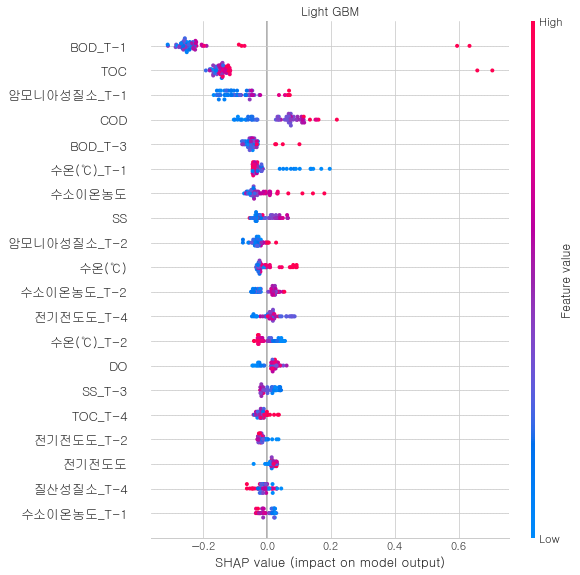

In [34]:
plt.title("Light GBM")
explainer = shap.TreeExplainer(LightGBM_tune)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
plt.show()

Text(0.5, 0.98, 'Light GBM Prediction Results')

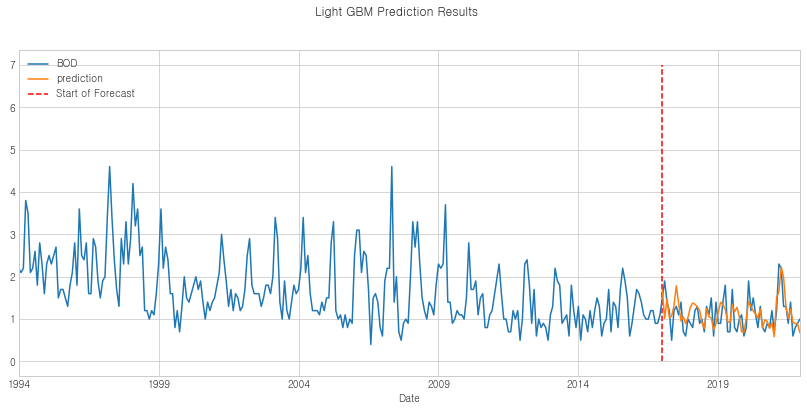

In [35]:
future_forecast = pd.DataFrame(pred_lgb_2, index=test_data.index, columns=['prediction'])
full_data_evaluation = pd.concat([data['BOD'], future_forecast], axis=1)
ax = full_data_evaluation.plot()
ax.vlines('2017-01-01',0,7,linestyle='--',color='r',label='Start of Forecast')
rcParams['figure.figsize'] = 14, 6
fig = ax.get_figure()
ax.legend(loc='upper left')
plt.suptitle(f'Light GBM Prediction Results')

### 3.) NGBoost

In [36]:
NGBoost = NGBRegressor(random_state=0)
NGBoost.fit(X_train, y_train)
Y_preds = NGBoost.predict(X_test)
Y_dists = NGBoost.pred_dist(X_test)

[iter 0] loss=1.1723 val_loss=0.0000 scale=1.0000 norm=0.8561
[iter 100] loss=0.6726 val_loss=0.0000 scale=1.0000 norm=0.5640
[iter 200] loss=0.3396 val_loss=0.0000 scale=1.0000 norm=0.4856
[iter 300] loss=0.0446 val_loss=0.0000 scale=1.0000 norm=0.4383
[iter 400] loss=-0.1982 val_loss=0.0000 scale=1.0000 norm=0.4006


In [37]:
y_test_reset_index = y_test.reset_index(drop=True)
y_test_reset_index = pd.DataFrame(y_test_reset_index,columns=['BOD'])

In [38]:
predictions = pd.DataFrame(Y_dists.loc, columns=['Predictions'])
predictions_upper = pd.DataFrame(Y_dists.dist.interval(0.95)[1], columns=['Predictions_upper'])
predictions_lower = pd.DataFrame(Y_dists.dist.interval(0.95)[0], columns=['Predictions_lower'])

In [39]:
df_figure = pd.concat([y_test_reset_index, predictions, predictions_lower, predictions_upper], axis=1)

MSE:0.114625,RMSE:0.338563,MAE:0.279153,MAPE:29.799417,SMAPE:12.765279


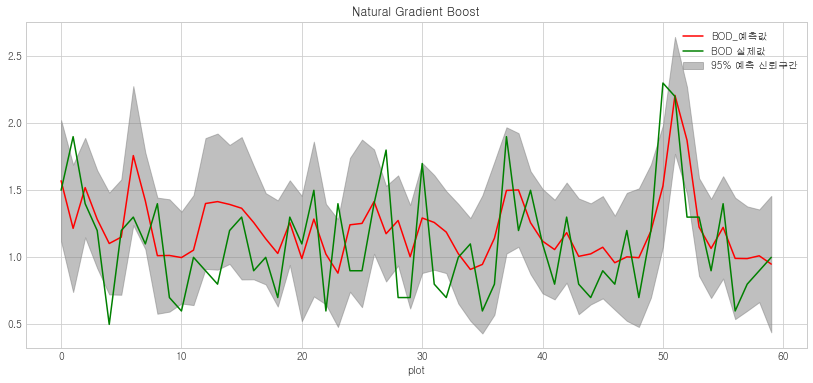

In [40]:
evaluate_regr(y_test,Y_preds)

def plot_results(df,title):
    fig, ax = plt.subplots(figsize=(14, 6))
    plt.plot(df.index, df.Predictions, label = 'BOD_예측값', color='r', lw=1.5)
    plt.fill_between(df.index, df.Predictions_lower,  df.Predictions_upper,label = '95% 예측 신뢰구간', color='gray', alpha=0.5)
    plt.plot(df.index, df['BOD'], label = 'BOD 실제값', color='g', lw=1.5)
    ax.legend(fontsize = 10)
    plt.title('Natural Gradient Boost')
    plt.xlabel(title)
    plt.show()
    
plot_results(df_figure,title='plot')

In [41]:
perm = PermutationImportance(NGBoost,random_state=0).fit(X_test,y_test)
eli5.show_weights(perm,feature_names=X_test.columns.to_list())

Weight,Feature
0.0368 ± 0.0357,질산성질소_T-4
0.0182 ± 0.0358,COD_T-2
0.0173 ± 0.0083,TOC_T-4
0.0172 ± 0.0315,TN
0.0159 ± 0.0070,DO_T-1
0.0083 ± 0.0081,TN_T-2
0.0083 ± 0.0138,암모니아성질소
0.0081 ± 0.0207,TP
0.0077 ± 0.0118,SS_T-4
0.0063 ± 0.0041,COD_T-4


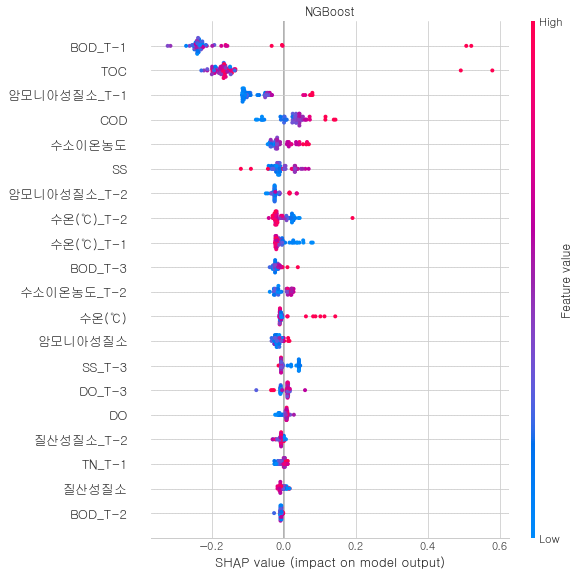

In [42]:
plt.title("NGBoost")
explainer = shap.TreeExplainer(NGBoost)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
plt.show()

Text(0.5, 0.98, 'NGBoost Prediction Results')

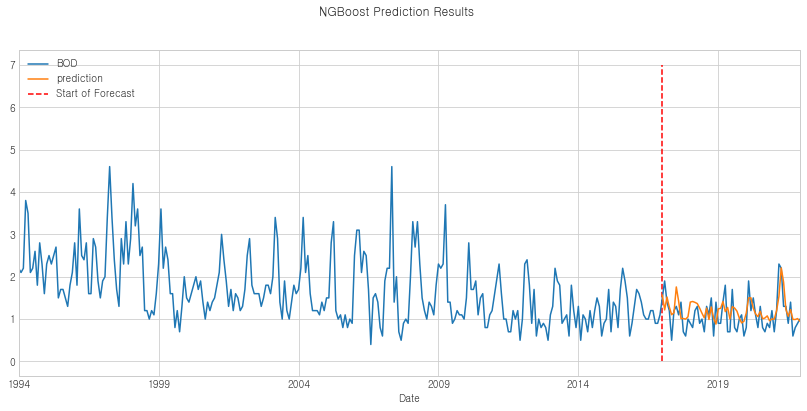

In [43]:
future_forecast = pd.DataFrame(Y_preds, index=test_data.index, columns=['prediction'])
full_data_evaluation = pd.concat([data['BOD'], future_forecast], axis=1)
ax = full_data_evaluation.plot()
ax.vlines('2017-01-01',0,7,linestyle='--',color='r',label='Start of Forecast')
rcParams['figure.figsize'] = 14, 6
fig = ax.get_figure()
ax.legend(loc='upper left')
plt.suptitle(f'NGBoost Prediction Results')

### 4.) Probabilistic Gradient Boost

In [44]:
PGBM  = PGBMRegressor(random_state=0) 
PGBM.fit(X_train, y_train)

#% Point and probabilistic predictions. By default, 100 probabilistic estimates are created
yhat_point = PGBM.predict(X_test)
yhat_dist = PGBM.predict_dist(X_test)

Estimator 0/100, Train metric: 0.7203
Estimator 1/100, Train metric: 0.6656
Estimator 2/100, Train metric: 0.6167
Estimator 3/100, Train metric: 0.5726
Estimator 4/100, Train metric: 0.5334
Estimator 5/100, Train metric: 0.4976
Estimator 6/100, Train metric: 0.4651
Estimator 7/100, Train metric: 0.4353
Estimator 8/100, Train metric: 0.4090
Estimator 9/100, Train metric: 0.3818
Estimator 10/100, Train metric: 0.3594
Estimator 11/100, Train metric: 0.3386
Estimator 12/100, Train metric: 0.3200
Estimator 13/100, Train metric: 0.3010
Estimator 14/100, Train metric: 0.2858
Estimator 15/100, Train metric: 0.2713
Estimator 16/100, Train metric: 0.2560
Estimator 17/100, Train metric: 0.2443
Estimator 18/100, Train metric: 0.2330
Estimator 19/100, Train metric: 0.2197
Estimator 20/100, Train metric: 0.2112
Estimator 21/100, Train metric: 0.2004
Estimator 22/100, Train metric: 0.1908
Estimator 23/100, Train metric: 0.1827
Estimator 24/100, Train metric: 0.1749
Estimator 25/100, Train metric: 0.1

MSE:0.122589,RMSE:0.350127,MAE:0.284668,MAPE:28.541673,SMAPE:12.659195


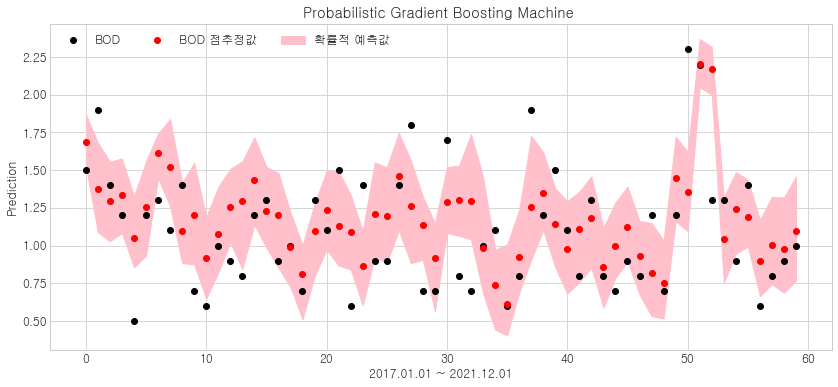

In [45]:
#%% Plot all samples
n_samples_plot = 60
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'figure.figsize':[14, 6]})
plt.plot(y_test[:n_samples_plot], 'o', label='BOD',color='black')
plt.plot(yhat_point[:n_samples_plot], 'ko', label='BOD 점추정값',color='red')
plt.fill_between(np.arange(len(y_test[:n_samples_plot])), 
                 yhat_dist.min(0)[:n_samples_plot], 
                 yhat_dist.max(0)[:n_samples_plot], 
                 color="pink", label='확률적 예측값')
plt.title('Probabilistic Gradient Boosting Machine ')
plt.xlabel('2017.01.01 ~ 2021.12.01')
plt.ylabel('Prediction')
plt.legend(ncol=3)
evaluate_regr(y_test,yhat_point)

Text(0.5, 0.98, 'PGBM Prediction Results')

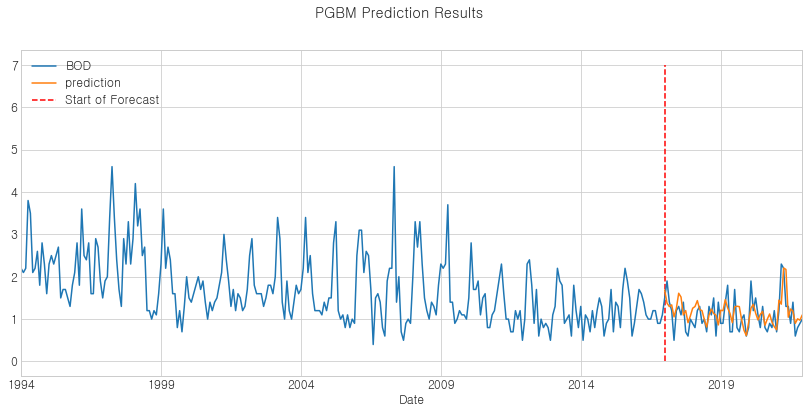

In [46]:
future_forecast = pd.DataFrame(yhat_point, index=test_data.index, columns=['prediction'])
full_data_evaluation = pd.concat([data['BOD'], future_forecast], axis=1)
ax = full_data_evaluation.plot()
ax.vlines('2017-01-01',0,7,linestyle='--',color='r',label='Start of Forecast')
rcParams['figure.figsize'] = 14, 6
fig = ax.get_figure()
ax.legend(loc='upper left')
plt.suptitle(f'PGBM Prediction Results')

In [47]:
evaluate_regr(y_test,pred_gbm)

MSE:0.107940,RMSE:0.328542,MAE:0.261365,MAPE:27.418752,SMAPE:12.011953


In [48]:
evaluate_regr(y_test,pred_xgb)

MSE:0.132191,RMSE:0.363581,MAE:0.288183,MAPE:29.767761,SMAPE:12.984644


In [49]:
evaluate_regr(y_test,pred_lgb_2)

MSE:0.107045,RMSE:0.327178,MAE:0.254955,MAPE:25.186137,SMAPE:11.503390


In [50]:
evaluate_regr(y_test,Y_preds)

MSE:0.114625,RMSE:0.338563,MAE:0.279153,MAPE:29.799417,SMAPE:12.765279


In [51]:
evaluate_regr(y_test,yhat_point)

MSE:0.122589,RMSE:0.350127,MAE:0.284668,MAPE:28.541673,SMAPE:12.659195
